# Data preparation for [Compass](https://github.com/YosefLab/Compass)

## Preparing novarino processed data for Compass

In [1]:
import scanpy as sc
import anndata as ad
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import mmread

from scipy.sparse import issparse
def normalize_tpm(adata, scale = 1e6):
    X = adata.X.toarray().T / adata.var.Length.values[:, None] * 1000
    factors = X.sum(axis = 0) / scale
    return X.T / factors[:, None]

def normalize_wtpm(adata, scale = 1e4):
    '''
    this function normalizes the data with a bug which turned out to might be useful
    i.e. it multiplies rpk sums by scale instead of dividing them 
    '''
    X = adata.X.toarray().T / adata.var.Length.values[:, None] * 1000
    factors = X.sum(axis = 0) * scale
    return X.T / factors[:, None]

def normalize_cpm(adata, scale = 1e6):
    X = adata.X.toarray().T 
    factors = X.sum(axis = 0) / scale
    return X.T / factors[:, None]

def write_expression(adataobj, file, layer = None, normalize = 'tpm'):
    adataobj = adataobj.copy()
    if layer:
        adataobj.X = adataobj.layers[layer]
    
    if normalize == 'tpm':
        X = normalize_tpm(adataobj)
        
    elif normalize == 'cpm':
        X = normalize_cpm(adataobj)
    
    elif normalize == 'wtpm':
        X = normalize_wtpm(adataobj)
        
    else:
        X = adataobj.X
    
    if issparse(X):
        X = X.toarray()
    
    df = pd.DataFrame(
        X.T,
        index = adataobj.var.index.to_list(),
        columns = adataobj.obs.index.to_list()
    )
    df.to_csv(
        file,
        sep = '\t'
    )

def data2h5ad(prefix):
    X = mmread(prefix + '.mtx').tocsr()
    obs = pd.read_csv(
        prefix + '.metadata.tsv',
        sep = '\t'
    )
    with open(prefix + f'.rownames.txt', 'r') as f:
        genes = [r.rstrip() for r in f]
    
    var = pd.DataFrame(
        index = genes
    )
    
    return ad.AnnData(
        X = X.T,
        obs = obs,
        var = var
    )

def splith5ad(adataobj, split_on):
    subsets = adataobj.obs[split_on].unique()
    return {subset: adataobj[adataobj.obs[split_on] == subset, :].copy() for subset in subsets}

In [31]:
adata = data2h5ad('../processed/novarino_scRNA')
adata

AnnData object with n_obs × n_vars = 203 × 26249
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'seq_folder', 'nUMI', 'nGene', 'log10GenesPerUMI', 'mitoRatio', 'cells', 'sample', 'sample_mouseID', 'sample_litter', 'sample_treatment', 'sample_sex', 'RNA_snn_res.0.9', 'seurat_clusters'

In [32]:
tmp = sc.read_h5ad('../processed/scRNAseq_featureCounts.h5ad')
genes = tmp.var.copy()
adata.var['Length'] = adata.var.merge(
    tmp.var,
    left_index = True,
    right_index = True
).Length

In [33]:
adata = adata[:, ~adata.var.Length.isna()].copy()

In [34]:
annotation = {
    0: 'olfactory_cells',
    1: 'oligodendrytes',
    2: 'astrocytes',
    3: 'neurons'
}
adata.obs['cell_type'] = adata.obs.seurat_clusters.apply(lambda x: annotation[x])
adata.obs

,orig.ident,nCount_RNA,nFeature_RNA,seq_folder,nUMI,nGene,log10GenesPerUMI,mitoRatio,cells,sample,sample_mouseID,sample_litter,sample_treatment,sample_sex,RNA_snn_res.0.9,seurat_clusters,cell_type
wt_162322,wt,62570,2514,SeuratProject,62723,2537,0.709614,0.065861,wt_162322,wt,GNF1/464,G1/59 A,prep 1,f,0,0,olfactory_cells
wt_162323,wt,99844,3289,SeuratProject,99977,3315,0.704111,0.043490,wt_162323,wt,GNF1/464,G1/59 A,prep 1,f,1,1,oligodendrytes
wt_162324,wt,107544,3215,SeuratProject,107931,3279,0.698518,0.121318,wt_162324,wt,GNF1/464,G1/59 A,prep 1,f,0,0,olfactory_cells
wt_162325,wt,136321,3141,SeuratProject,136624,3172,0.681787,0.037987,wt_162325,wt,GNF1/464,G1/59 A,prep 1,f,3,3,neurons
wt_162326,wt,109397,3513,SeuratProject,109533,3537,0.704158,0.073549,wt_162326,wt,GNF1/464,G1/59 A,prep 1,f,3,3,neurons
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ko_162553,ko,331737,4999,SeuratProject,332022,5055,0.670822,0.071040,ko_162553,ko,GN21/475,G1/59 B,prep 2,f,3,3,neurons
ko_162554,ko,435996,5670,SeuratProject,436357,5742,0.666519,0.042850,ko_162554,ko,GN21/475,G1/59 B,prep 2,f,3,3,neurons
ko_162555,ko,260654,4243,SeuratProject,260946,4306,0.670920,0.062971,ko_162555,ko,GN21/475,G1/59 B,prep 2,f,0,0,olfactory_cells
ko_162556,ko,211388,3149,SeuratProject,211590,3177,0.657595,0.034033,ko_162556,ko,GN21/475,G1/59 B,prep 2,f,0,0,olfactory_cells


In [35]:
data = {}
for celltype in annotation.values():
    for sample in ['wt', 'ko']:
        tmp = adata[(adata.obs.cell_type == celltype) & (adata.obs['sample'] == sample), :].copy()
        data[celltype + '_' + sample] = tmp[:, ~(np.array((adata.X > 0).sum(axis = 0)).flatten() == 0)]
data

{'olfactory_cells_wt': View of AnnData object with n_obs × n_vars = 35 × 25854
     obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'seq_folder', 'nUMI', 'nGene', 'log10GenesPerUMI', 'mitoRatio', 'cells', 'sample', 'sample_mouseID', 'sample_litter', 'sample_treatment', 'sample_sex', 'RNA_snn_res.0.9', 'seurat_clusters', 'cell_type'
     var: 'Length',
 'olfactory_cells_ko': View of AnnData object with n_obs × n_vars = 20 × 25854
     obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'seq_folder', 'nUMI', 'nGene', 'log10GenesPerUMI', 'mitoRatio', 'cells', 'sample', 'sample_mouseID', 'sample_litter', 'sample_treatment', 'sample_sex', 'RNA_snn_res.0.9', 'seurat_clusters', 'cell_type'
     var: 'Length',
 'oligodendrytes_wt': View of AnnData object with n_obs × n_vars = 33 × 25854
     obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'seq_folder', 'nUMI', 'nGene', 'log10GenesPerUMI', 'mitoRatio', 'cells', 'sample', 'sample_mouseID', 'sample_litter', 'sample_treatment', 'sample_sex', 'RNA_s

In [37]:
for key in data.keys():
    write_expression(
        data[key], 
        f'../processed/novarino_tpm/{key}.expression.tsv',
        normalize = 'tpm'
    )

## Preparing featureCounts and Salmon quantification for Compass

In [38]:
fdata_obs = sc.read_h5ad('../processed/scRNAseq_featureCounts.clustered.h5ad').obs.copy()
fdata = sc.read_h5ad('../processed/scRNAseq_featureCounts.h5ad')[fdata_obs.index, :].copy()
fdata.obs = fdata_obs
sdata_obs = sc.read_h5ad('../processed/scRNAseq_salmon.clustered.h5ad').obs.copy()
sdata = sc.read_h5ad('../processed/scRNAseq_salmon.h5ad')[sdata_obs.index, :].copy()
sdata.obs = sdata_obs

data = {}
for key, adata in zip( 
    ['featureCounts', 'salmon'],
    [fdata, sdata]
):
    tmp = {}
    for celltype in annotation.values():
        for sample in ['wt', 'ko']:
            tmp_adata = adata[(adata.obs.cell_type == celltype) & (adata.obs['sample_genotype'] == sample), :].copy()
            tmp[celltype + '_' + sample] = tmp_adata[:, ~(np.array((adata.X > 0).sum(axis = 0)).flatten() == 0)].copy()
    
    data[key] = tmp

data

{'featureCounts': {'olfactory_cells_wt': AnnData object with n_obs × n_vars = 32 × 40436
      obs: 'sample_description', 'sample_genotype', 'sample_treatment', 'sample_sex', 'sample_litter', 'sample_mouseID', 'nCount_RNA', 'nFeature_RNA', 'percent_mt', 'percent_ribo', 'leiden_r0.25', 'leiden_r0.5', 'leiden_r0.75', 'leiden_r1', 'cell_type'
      var: 'Length',
  'olfactory_cells_ko': AnnData object with n_obs × n_vars = 20 × 40436
      obs: 'sample_description', 'sample_genotype', 'sample_treatment', 'sample_sex', 'sample_litter', 'sample_mouseID', 'nCount_RNA', 'nFeature_RNA', 'percent_mt', 'percent_ribo', 'leiden_r0.25', 'leiden_r0.5', 'leiden_r0.75', 'leiden_r1', 'cell_type'
      var: 'Length',
  'oligodendrytes_wt': AnnData object with n_obs × n_vars = 32 × 40436
      obs: 'sample_description', 'sample_genotype', 'sample_treatment', 'sample_sex', 'sample_litter', 'sample_mouseID', 'nCount_RNA', 'nFeature_RNA', 'percent_mt', 'percent_ribo', 'leiden_r0.25', 'leiden_r0.5', 'leiden_

In [39]:
import os
for key in data.keys():
    path = f'../processed/{key}'
    if not os.path.exists(path):
        os.mkdir(path)

key1 = 'salmon'
for key2, adata in data[key1].items():
    write_expression(
        adata, 
        f'../processed/{key1}_wtpm/{key2}.expression.tsv',
        layer = 'counts',
        normalize = 'wtpm'
    )
    
key1 = 'featureCounts'
for key2, adata in data[key1].items():
    write_expression(
        adata, 
        f'../processed/{key1}_wtpm/{key2}.expression.tsv',
        normalize = 'tpm'
    )

## Preparing bulk RNAseq for Compass

In [12]:
import gzip
import re
def read_feature_counts(
    filename, 
    clean_regex = None,
    rename_columns = None
):
    with gzip.open(filename) as file:
        #getting rid of comment
        file.readline()
        
        tab = pd.read_csv(
            file,
            sep = '\t'
        )
        
    exclude_cols = ['Chr', 'Start', 'End', 'Strand']
    if clean_regex:
        new_columns = []
        for col in tab.columns:
            match = re.findall(clean_regex, col)
            if match:
                new_columns.append(match[0])
                
            else:
                new_columns.append(col)
                
        tab.columns = new_columns
    
    if rename_columns:
        tab.rename(
            columns = rename_columns,
            inplace = True
        )
    
    return tab.loc[:, ~tab.columns.isin(exclude_cols)]

In [13]:
meta = pd.read_csv('../meta/sampleList_Slc7a5_EmxCre_P1_Ctx.csv')
meta

,sample_ID,sequence,genotype,timepoint,sex,litter,barcode,name
0,81446,GTGCCA,wt,P1,m,1,7049,A_wt
1,81447,TCGAGG,ko,P1,m,1,7050,A_ko
2,81448,CACTAA,wt,P1,f,1,7051,B_wt
3,81449,GGTATA,ko,P1,f,1,7052,B_ko
4,81450,CGCCTG,wt,P1,m,2,7053,C_wt
5,81451,AATGAA,ko,P1,m,2,7054,C_ko


In [14]:
sample_type = {
    key: meta.loc[meta.genotype == key, 'sample_ID'].tolist() for key in ['wt', 'ko']
}
sample_type

{'wt': [81446, 81448, 81450], 'ko': [81447, 81449, 81451]}

In [15]:
df_featureCounts = read_feature_counts(
    '../raw/RNA_featureCounts.tsv.gz',
    clean_regex = '[0-9]{5}',
    rename_columns = {
        'Geneid': 'gene_name'
    }
)

X = df_featureCounts.loc[:, df_featureCounts.columns.str.startswith('8')].values / df_featureCounts.Length.values[:, None] * 1000
factors = X.sum(axis = 0) / 1e6
df_featureCounts.loc[:, df_featureCounts.columns.str.startswith('8')] = X / factors
# zero_expression_genes = df_featureCounts[
#     (df_featureCounts.loc[:, df_featureCounts.columns[df_featureCounts.columns.str.startswith('8')]] == 0).all(axis = 1)
# ]
# df_featureCounts.drop(
#     columns = 'Length',
#     index = zero_expression_genes.index
# )
df_featureCounts.set_index(
    'gene_name',
    inplace = True
)
df_featureCounts.index.name = None
df_featureCounts

,Length,81446,81447,81448,81449,81450,81451
4933401J01Rik,1070,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
Gm26206,110,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
Xkr4,6094,29.669137,24.213824,24.332219,25.701282,25.134798,27.160686
Gm18956,480,0.000000,0.000000,4.752581,7.501131,4.198779,16.820856
Gm37180,2819,48.965217,47.437170,40.461849,60.668955,42.181420,61.579011
...,...,...,...,...,...,...,...
mt-Nd6,519,1771.814280,2016.853483,1898.834837,1706.615662,1809.600956,1804.595863
mt-Te,69,169.054437,133.658553,132.245743,104.363559,116.835591,117.014649
mt-Cytb,1144,1845.560198,1958.962376,2045.936443,1776.666443,1944.944922,1870.290963
mt-Tt,67,580.336128,447.357172,442.628477,456.785281,511.373686,512.157401


In [16]:
df_salmon = pd.read_csv(
    '../raw/RNA_salmon_quant_tpm.tsv.gz',
    sep = '\t',
    compression = 'gzip'
)
df_salmon.set_index(
    'gene_name',
    inplace = True
)
df_salmon.index.name = None
df_salmon

,Length,gene_id,81446,81447,81448,81449,81450,81451
0610005C13Rik,3583,ENSMUSG00000109644.2,0.430413,0.355705,0.200148,0.295800,0.246198,0.364364
0610006L08Rik,2128,ENSMUSG00000108652.2,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
0610009B22Rik,998,ENSMUSG00000007777.10,6.510933,5.957220,7.262461,10.436020,8.559581,5.558127
0610009E02Rik,1803,ENSMUSG00000086714.2,1.251554,1.448534,2.135169,3.813021,2.110855,2.137491
0610009L18Rik,619,ENSMUSG00000043644.5,9.021717,6.975433,7.106079,7.876659,9.057562,7.501791
...,...,...,...,...,...,...,...,...
n-R5s88,118,ENSMUSG00000065107.4,9.405298,9.806197,0.000000,7.858370,0.000000,0.000000
n-R5s92,119,ENSMUSG00000119822.1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
n-R5s93,119,ENSMUSG00000119639.1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
snoZ159,87,ENSMUSG00002075734.1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


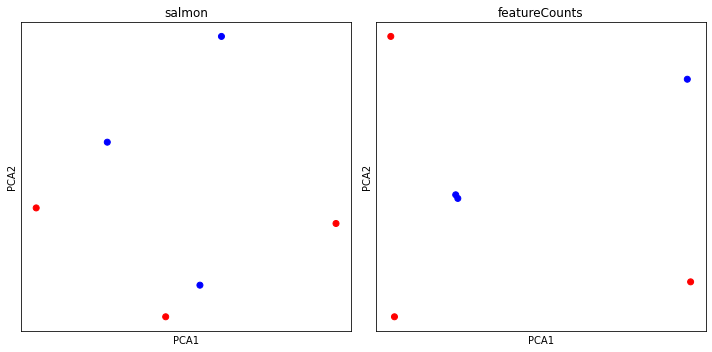

In [17]:
from sklearn.decomposition import PCA
fig, axs = plt.subplots(1, 2)
pca = PCA(n_components = 2)

for key, df, ax in zip(['salmon', 'featureCounts'], [df_salmon, df_featureCounts], axs):
    pca_transform = pca.fit_transform(
        df.loc[:, df.columns[df.columns.str.startswith('8')]].values.T
    )
    ax.scatter(
        pca_transform[:, 0],
        pca_transform[:, 1],
        color = ['b', 'r', 'b', 'r', 'b', 'r']
    )
    ax.set_title(key)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xlabel('PCA1')
    ax.set_ylabel('PCA2')
    
fig.set_figwidth(10)
fig.set_figheight(5)
fig.tight_layout()

In [25]:
for key1, df in zip(
    ['salmon', 'featureCounts'],
    [df_salmon, df_featureCounts]
):
    path = f'../processed/{key1}_rna'
    if not os.path.exists(path):
        os.mkdir(path)
        
    for key2, sampleids in sample_type.items():
        sampleids = [str(i) for i in sampleids]
        tmp = df.loc[:, sampleids]
        tmp = tmp.loc[~((df.loc[:, sampleids] > 0).sum(axis = 1) == 0), :]
        tmp.to_csv(
            path + f'/{key2}.expression.tsv',
            sep = '\t'
        )

## Timeseries

In [2]:
adata = sc.read_h5ad(
    '../data/mouse_brain_development.h5ad'
)
adata

AnnData object with n_obs × n_vars = 89831 × 26589
    obs: 'class_label', 'subclass_label', 'developmental_stage'

In [3]:
tmp = sc.read_h5ad('../processed/scRNAseq_featureCounts.h5ad')
genes = tmp.var.copy()
adata.var['Length'] = adata.var.merge(
    tmp.var,
    left_index = True,
    right_index = True
).Length
adata = adata[:, ~adata.var.Length.isna()].copy()
adata

AnnData object with n_obs × n_vars = 89831 × 25539
    obs: 'class_label', 'subclass_label', 'developmental_stage'
    var: 'Length'

Immature Glutamatergic
AnnData object with n_obs × n_vars = 2196 × 25539
    obs: 'class_label', 'subclass_label', 'developmental_stage'
    var: 'Length'
Progenitors
AnnData object with n_obs × n_vars = 1058 × 25539
    obs: 'class_label', 'subclass_label', 'developmental_stage'
    var: 'Length'
Mature Glutamatergic
AnnData object with n_obs × n_vars = 78235 × 25539
    obs: 'class_label', 'subclass_label', 'developmental_stage'
    var: 'Length'
GABAergic
AnnData object with n_obs × n_vars = 5054 × 25539
    obs: 'class_label', 'subclass_label', 'developmental_stage'
    var: 'Length'
Non-Neuronal
AnnData object with n_obs × n_vars = 3288 × 25539
    obs: 'class_label', 'subclass_label', 'developmental_stage'
    var: 'Length'


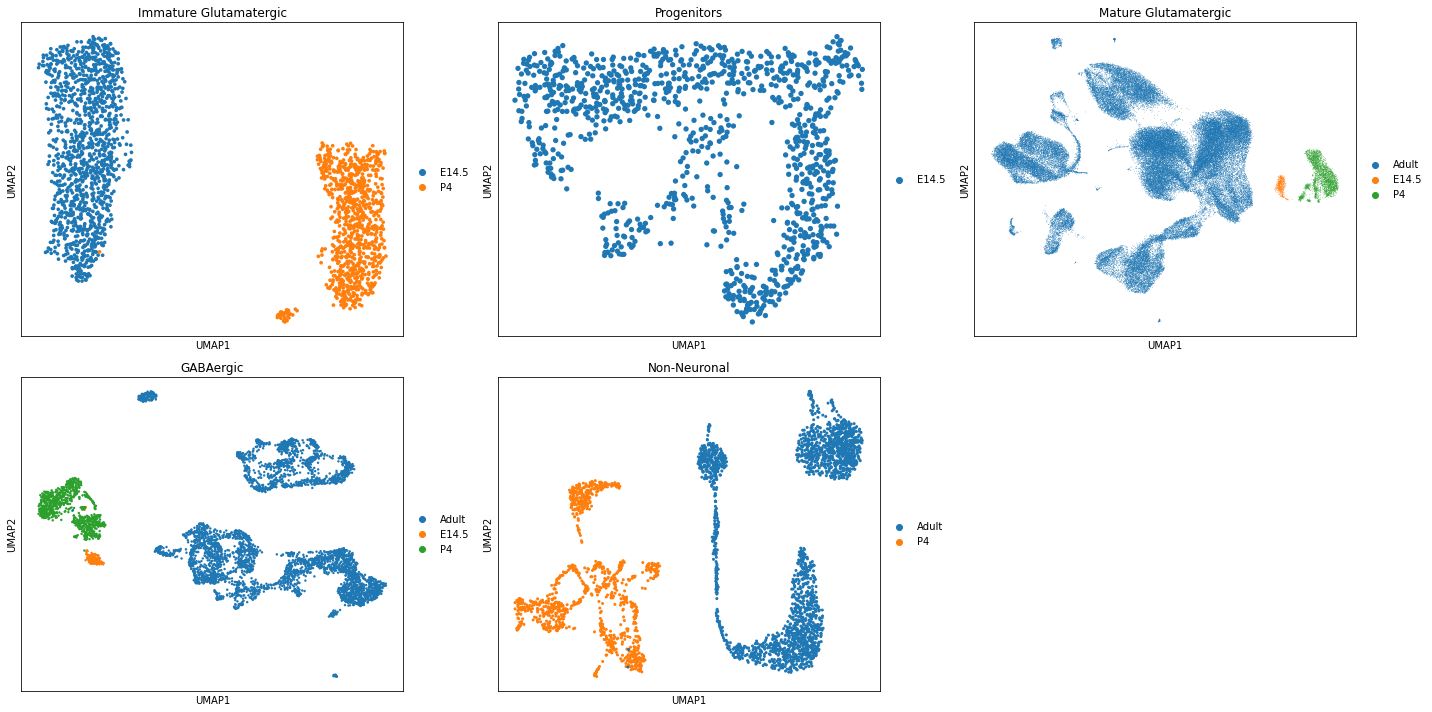

In [4]:
fig, axs = plt.subplots(2, 3)
axs = axs.reshape(6)
axs[-1].remove()
axs = axs[:-1]

for cell_type, ax in zip(adata.obs.class_label.unique(), axs):
    tmp = adata[adata.obs.class_label == cell_type, :].copy()
    print(cell_type)
    print(tmp)
    tmp.layers['counts'] = tmp.X.copy()
    sc.pp.normalize_total(tmp)
    sc.pp.log1p(tmp)
    sc.pp.scale(tmp)
    sc.pp.highly_variable_genes(
        tmp,
        n_top_genes=2000,
        layer = 'counts',
        flavor = 'seurat_v3',
        subset = True
    )
    sc.pp.pca(
        tmp, 
        n_comps = 40, 
        svd_solver = 'arpack',
        use_highly_variable = True,
    )
    sc.pp.neighbors(tmp)
    sc.tl.umap(tmp)
    import matplotlib.pyplot as plt
    sc.pl.umap(
        tmp,
        color = 'developmental_stage',
        show = False,
        ax = ax
    )
    ax.set_title(cell_type)

fig.set_figwidth(20)
fig.set_figheight(10)
fig.tight_layout()

Immature Glutamatergic
AnnData object with n_obs × n_vars = 2196 × 25539
    obs: 'class_label', 'subclass_label', 'developmental_stage'
    var: 'Length'
Progenitors
AnnData object with n_obs × n_vars = 1058 × 25539
    obs: 'class_label', 'subclass_label', 'developmental_stage'
    var: 'Length'
Mature Glutamatergic
AnnData object with n_obs × n_vars = 78235 × 25539
    obs: 'class_label', 'subclass_label', 'developmental_stage'
    var: 'Length'
GABAergic
AnnData object with n_obs × n_vars = 5054 × 25539
    obs: 'class_label', 'subclass_label', 'developmental_stage'
    var: 'Length'
Non-Neuronal
AnnData object with n_obs × n_vars = 3288 × 25539
    obs: 'class_label', 'subclass_label', 'developmental_stage'
    var: 'Length'


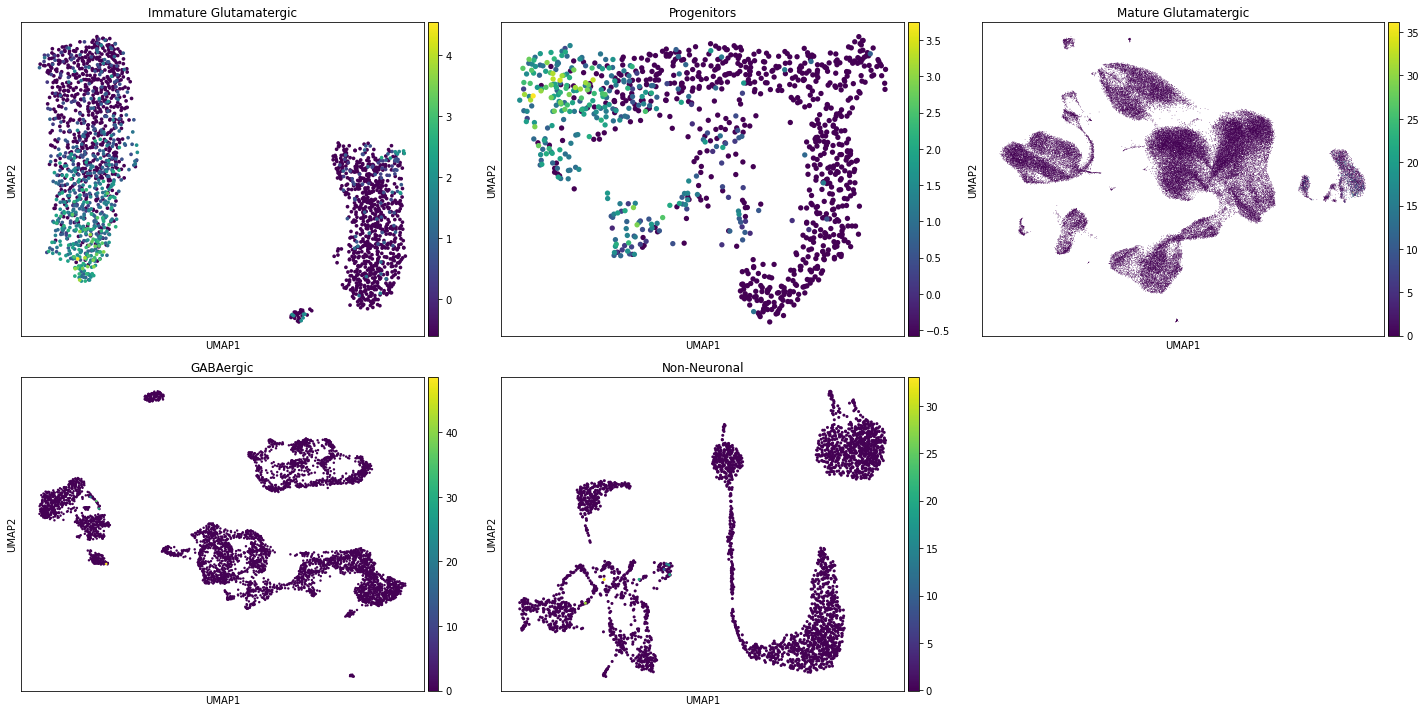

In [14]:
fig, axs = plt.subplots(2, 3)
axs = axs.reshape(6)
axs[-1].remove()
axs = axs[:-1]

for cell_type, ax in zip(adata.obs.class_label.unique(), axs):
    tmp = adata[adata.obs.class_label == cell_type, :].copy()
    print(cell_type)
    print(tmp)
    tmp.layers['counts'] = tmp.X.copy()
    sc.pp.normalize_total(tmp)
    sc.pp.log1p(tmp)
    sc.pp.scale(tmp)
    sc.pp.highly_variable_genes(
        tmp,
        n_top_genes=2000,
        layer = 'counts',
        flavor = 'seurat_v3',
    )
    sc.pp.pca(
        tmp, 
        n_comps = 40, 
        svd_solver = 'arpack',
        use_highly_variable = True,
    )
    sc.pp.neighbors(tmp)
    sc.tl.umap(tmp)
    import matplotlib.pyplot as plt
    sc.pl.umap(
        tmp,
        color = 'Neurod1',
        show = False,
        ax = ax
    )
    ax.set_title(cell_type)

fig.set_figwidth(20)
fig.set_figheight(10)
fig.tight_layout()

In [ ]:
for devstage in adata.obs.developmental_stage.unique():
    for cell_type in adata.obs.loc[adata.obs.developmental_stage == devstage, 'class_label'].unique():   
        index = (adata.obs.class_label == cell_type) & (adata.obs.developmental_stage == devstage)
        tmp = adata[index].copy()
        if tmp.X.shape[0]:
            s1 = devstage.replace('.', '_')
            s2 = cell_type.replace(' ', '_').replace('-', '_')
            write_expression(
                tmp, 
                f'../processed/timeseries_tpm/{s1}_{s2}.expression.tsv',
                normalize = 'tpm'
            )

In [61]:
adata.obs.groupby(['class_label', 'developmental_stage']).count() // 100

subclass_label
class_label            developmental_stage                
GABAergic              Adult                            40
                       E14.5                             1
                       P4                                8
Immature Glutamatergic Adult                             0
                       E14.5                            12
                       P4                                9
Mature Glutamatergic   Adult                           742
                       E14.5                             6
                       P4                               33
Non-Neuronal           Adult                            21
                       E14.5                             0
                       P4                               10
Progenitors            Adult                             0
                       E14.5                            10
                       P4                                0